In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import string
import warnings
from pathlib import Path
from time import time

import arviz as az
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
from theano import tensor as tt

In [3]:
from src.command_line_interfaces import sampling_pymc3_models_cli as sampling
from src.command_line_interfaces.cli_helpers import ModelOption
from src.data_processing import achilles as achelp
from src.data_processing import common as dphelp
from src.io import data_io
from src.modeling import pymc3_analysis as pmanal
from src.modeling import pymc3_sampling_api as pmapi
from src.plot.color_pal import ModelColors, SeabornColor

In [4]:
notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_classic())
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 341
np.random.seed(RANDOM_SEED)

HDI_PROB = 0.89

## Data

In [5]:
dm_guide_efficacy = pd.read_csv(
    data_io.data_path(data_io.DataFile.achilles_guide_efficacy)
)

dm_essentials = pd.read_csv(data_io.data_path(data_io.DataFile.achilles_essentials))

essential_genes = dm_essentials.gene[dm_essentials.essential]
nonessential_genes = dm_essentials.gene[~dm_essentials.essential]

print(f"    num. essential genes: {len(essential_genes)}")
print(f"num. non-essential genes: {len(nonessential_genes)}")

    num. essential genes: 1246
num. non-essential genes: 758


In [6]:
speclet_one_fit = sampling.sample_speclet_model(ModelOption.speclet_one, "SpecletOne")

(INFO) Cache directory: /n/data2/dfci/cancerbio/haigis/Cook/speclet/models/model_cache/pymc3_model_cache/SpecletOne
(INFO) Sampling 'speclet_one' with custom name 'SpecletOne'
(INFO) Running model build method.
(INFO) Running ADVI fitting method.
/home/jc604/.conda/envs/speclet/lib/python3.9/site-packages/pymc3/data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/jc604/.conda/envs/speclet/lib/python3.9/site-packages/pymc3/data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
(INFO) finished; execution time: 2.70 minutes


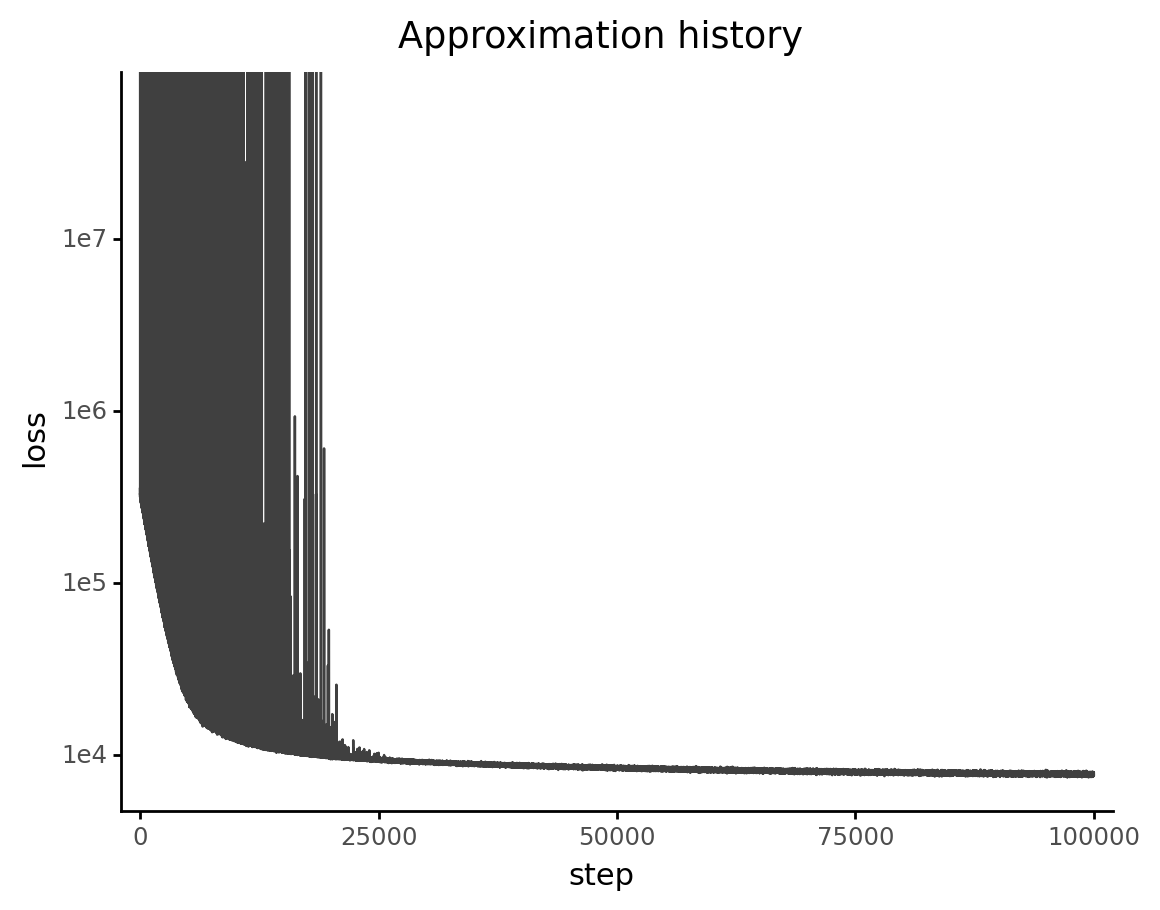

<ggplot: (8750742499386)>

In [7]:
(pmanal.plot_vi_hist(speclet_one_fit.advi_results.approximation) + gg.scale_y_log10())

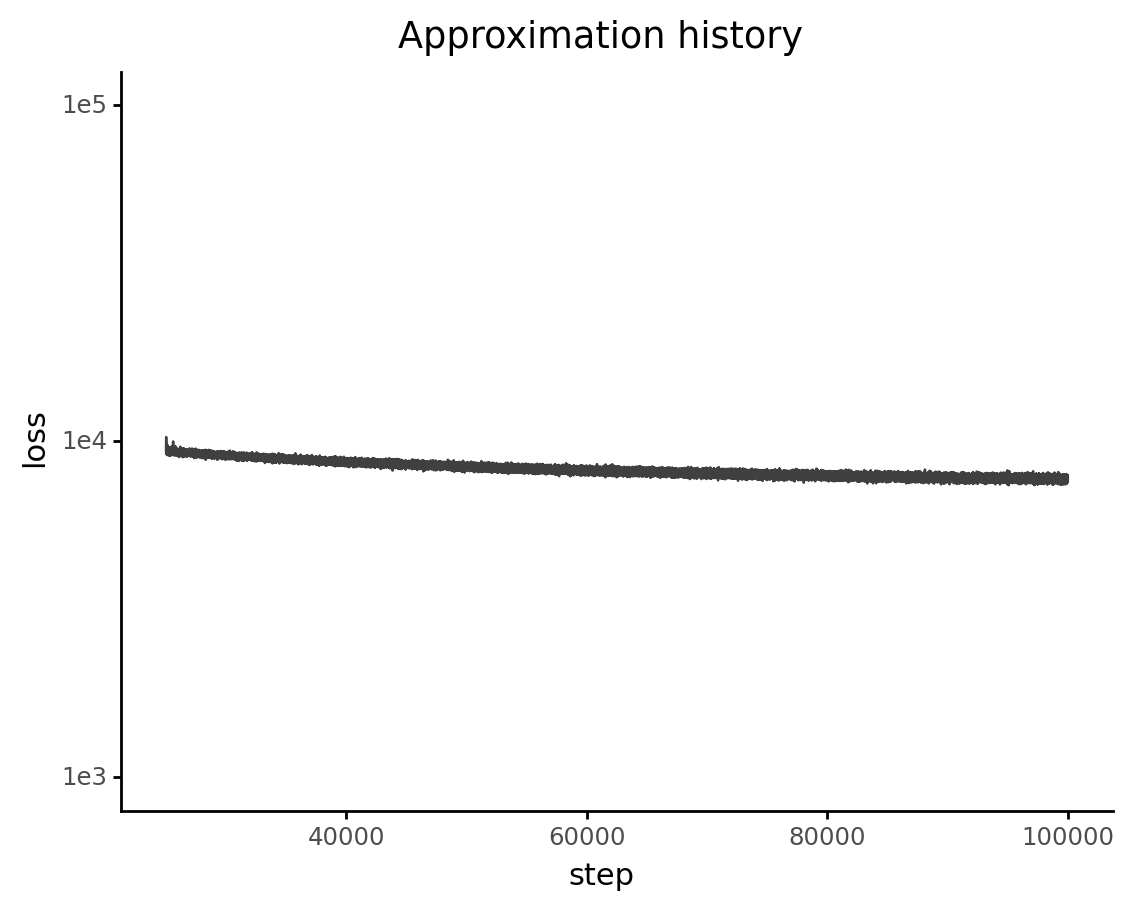

<ggplot: (8750739578537)>

In [8]:
(
    pmanal.plot_vi_hist(speclet_one_fit.advi_results.approximation)
    + gg.scale_x_continuous(limits=(25000, None))
    + gg.scale_y_log10(limits=(1e3, 1e5))
)

In [9]:
az_speclet_one = pmapi.convert_samples_to_arviz(
    speclet_one_fit.model, speclet_one_fit.advi_results
)

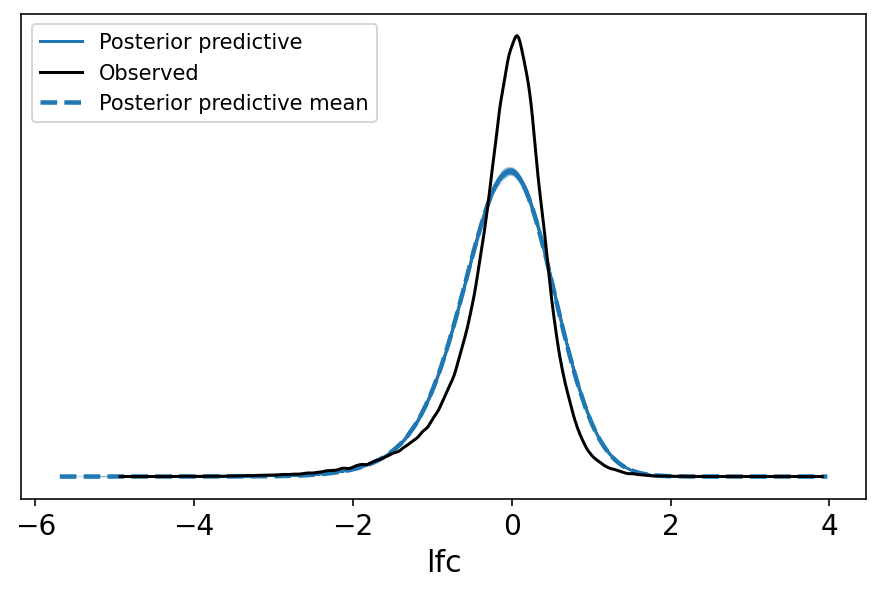

In [10]:
az.plot_ppc(az_speclet_one, num_pp_samples=100, random_seed=0);

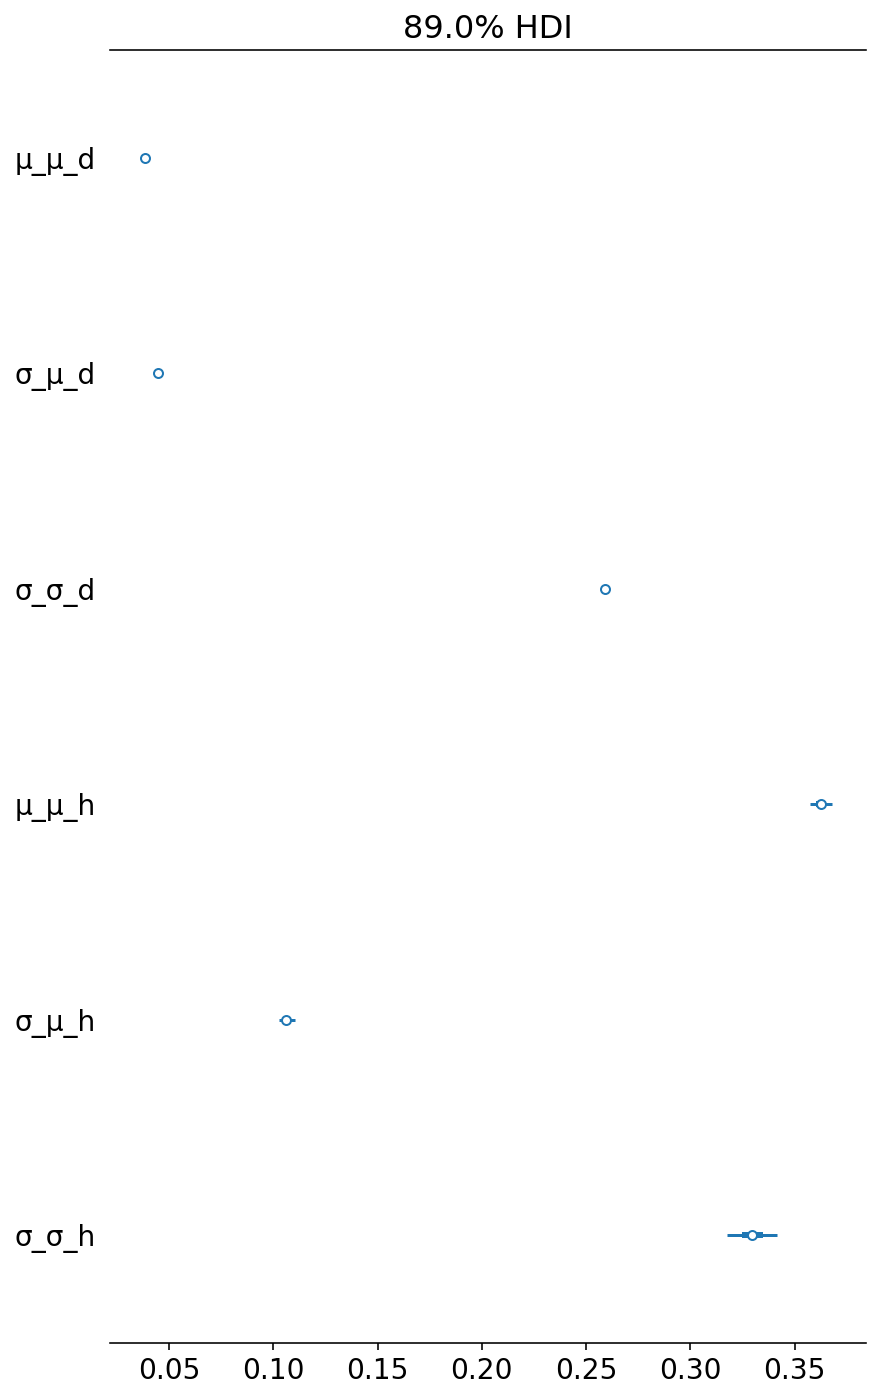

In [11]:
az.plot_forest(
    az_speclet_one,
    var_names=["μ_μ_d", "σ_μ_d", "σ_σ_d", "μ_μ_h", "σ_μ_h", "σ_σ_h"],
    hdi_prob=HDI_PROB,
);

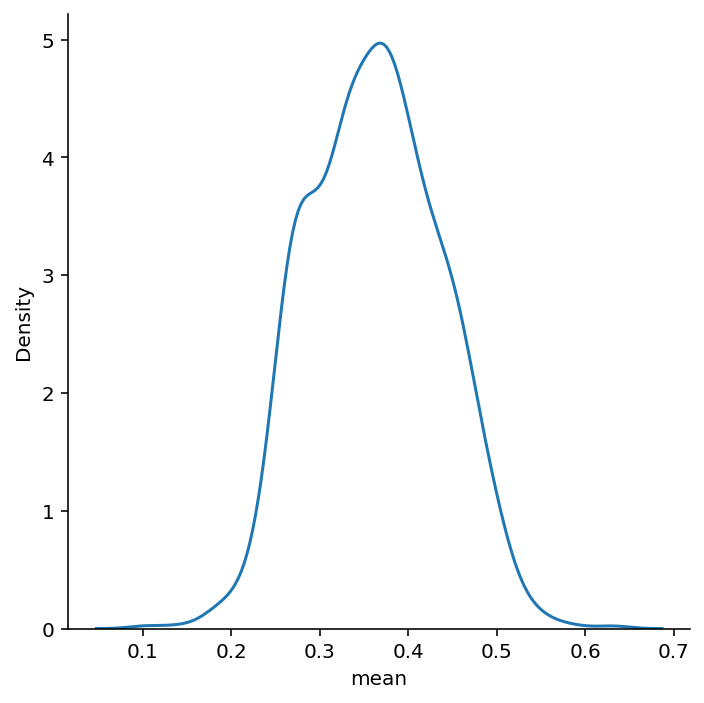

In [12]:
s1_gene_consistent = (
    az.summary(az_speclet_one, var_names="μ_h", kind="stats", hdi_prob=HDI_PROB)
    .reset_index(drop=False)
    .rename(columns={"index": "param_idx"})
    .assign(hugo_symbol=speclet_one_fit.data.hugo_symbol.cat.categories)
)

sns.displot(s1_gene_consistent, x="mean", kind="kde");

In [13]:
s1_gene_effect = (
    az.summary(az_speclet_one, var_names="μ_d", kind="stats", hdi_prob=HDI_PROB)
    .reset_index(drop=False)
    .rename(columns={"index": "param_idx"})
    .pipe(
        pmanal.extract_matrix_variable_indices,
        col="param_idx",
        idx1=speclet_one_fit.data["hugo_symbol"].cat.categories,
        idx2=speclet_one_fit.data["depmap_id"].cat.categories,
        idx1name="hugo_symbol",
        idx2name="depmap_id",
    )
)

s1_gene_effect.head()

,param_idx,mean,sd,hdi_5.5%,hdi_94.5%,hugo_symbol,depmap_id
0,"μ_d[0,0]",0.043,0.044,-0.026,0.112,A2ML1,ACH-000007
1,"μ_d[0,1]",0.036,0.041,-0.026,0.100,A2ML1,ACH-000009
2,"μ_d[0,2]",0.031,0.044,-0.033,0.104,A2ML1,ACH-000202
3,"μ_d[0,3]",0.044,0.043,-0.019,0.115,A2ML1,ACH-000249
4,"μ_d[0,4]",0.039,0.044,-0.031,0.109,A2ML1,ACH-000253


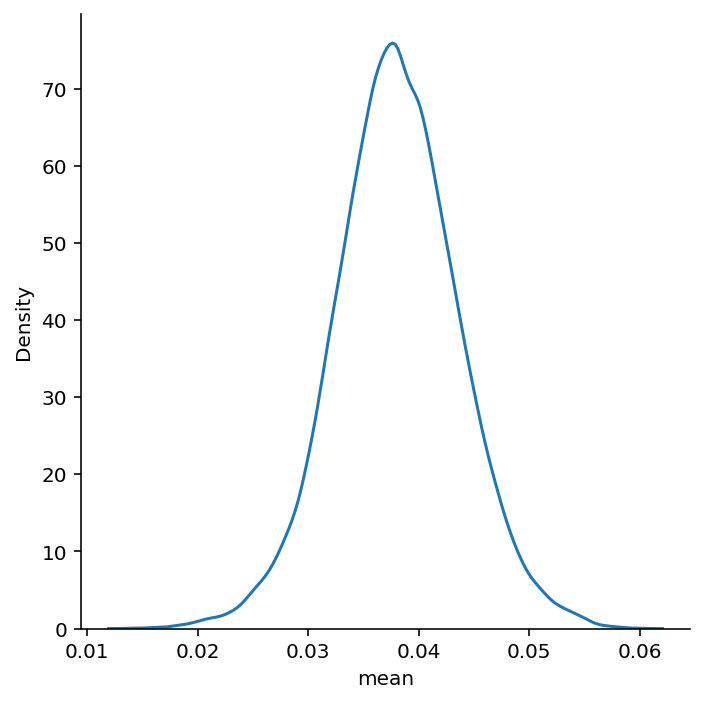

In [14]:
sns.displot(s1_gene_effect, x="mean", kind="kde");

In [15]:
s1_gene_effect.query("hugo_symbol == 'KRAS'").head(10)

,param_idx,mean,sd,hdi_5.5%,hdi_94.5%,hugo_symbol,depmap_id
16272,"μ_d[452,0]",0.028,0.044,-0.041,0.100,KRAS,ACH-000007
16273,"μ_d[452,1]",0.026,0.046,-0.043,0.100,KRAS,ACH-000009
16274,"μ_d[452,2]",0.048,0.045,-0.020,0.123,KRAS,ACH-000202
16275,"μ_d[452,3]",0.035,0.044,-0.041,0.097,KRAS,ACH-000249
16276,"μ_d[452,4]",0.048,0.044,-0.019,0.126,KRAS,ACH-000253
16277,"μ_d[452,5]",0.033,0.044,-0.037,0.103,KRAS,ACH-000286
16278,"μ_d[452,6]",0.047,0.043,-0.025,0.111,KRAS,ACH-000296
16279,"μ_d[452,7]",0.027,0.047,-0.051,0.098,KRAS,ACH-000350
16280,"μ_d[452,8]",0.027,0.044,-0.040,0.097,KRAS,ACH-000381
16281,"μ_d[452,9]",0.025,0.046,-0.056,0.089,KRAS,ACH-000403


---

In [3]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 0.00 minutes


In [4]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-03-17

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.21.0

Compiler    : Clang 11.0.1 
OS          : Darwin
Release     : 20.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac

Git branch: crc-m2

matplotlib: 3.3.4
plotnine  : 0.7.1
re        : 2.2.1
arviz     : 0.11.2
sys       : 3.9.2 | packaged by conda-forge | (default, Feb 21 2021, 05:02:20) 
[Clang 11.0.1 ]
numpy     : 1.20.1
theano    : 1.0.5
pymc3     : 3.11.1
seaborn   : 0.11.1
pandas    : 1.2.3

